## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

### get all objective points and image points from chessboard images

In [4]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib qt

In [13]:

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()
print("Camera Calibration has finished")

Camera Calibration has finished


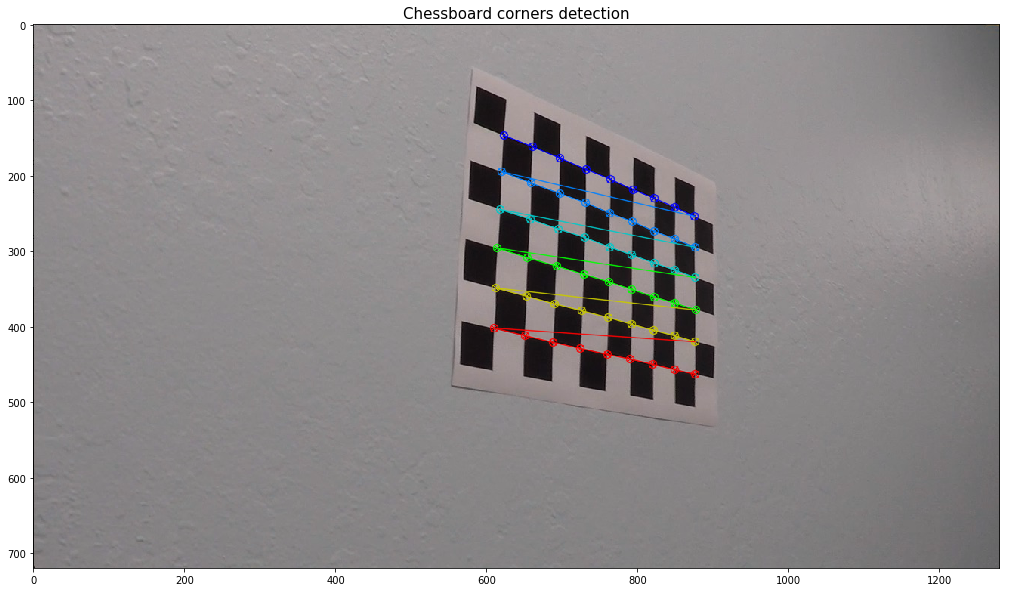

In [25]:
# an example of chessboard corners
plt.figure(figsize=(20,10))
plt.imshow(img)
plt.title('Chessboard corners detection', fontsize=15)

camera calibration matrix is
[[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]

distortion coefficients are
[[ -2.41017956e-01  -5.30721171e-02  -1.15810354e-03  -1.28318858e-04
    2.67125301e-02]]


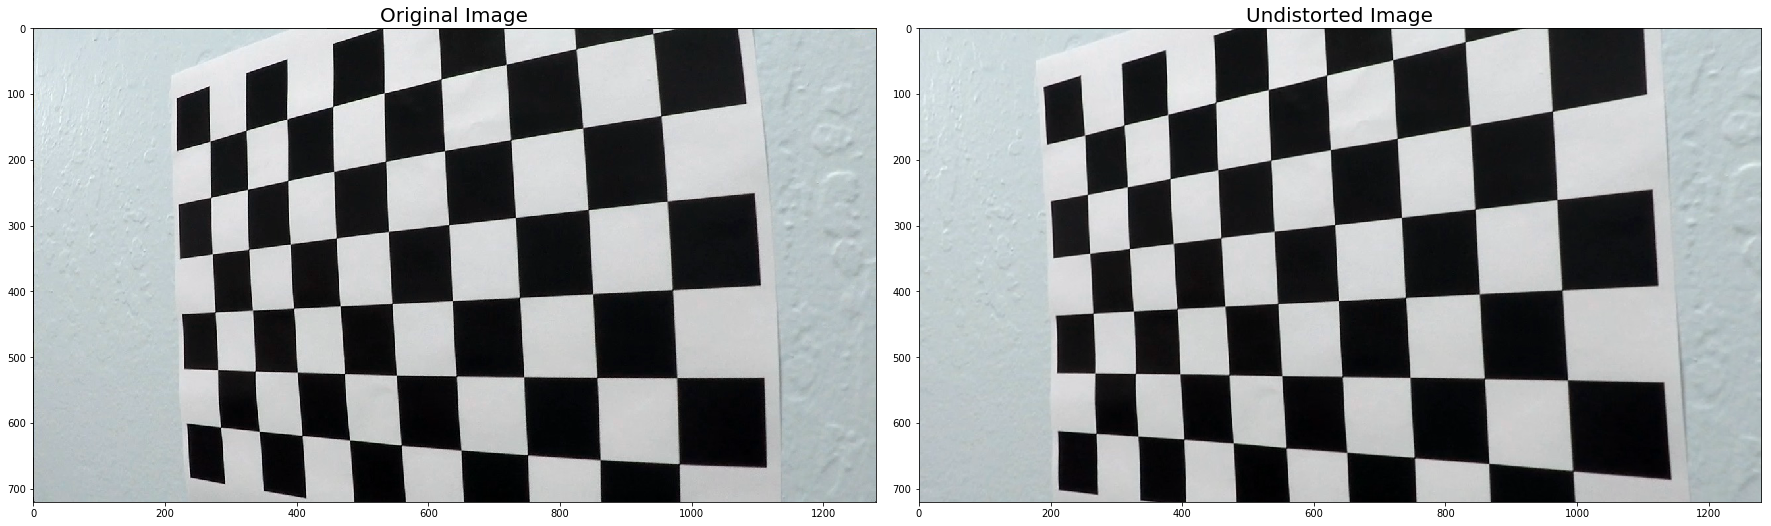

In [26]:
# function to return undistorted image: 
def undistort(img, objpoints, imgpoints):
    #img = cv2.imread(image)
    img_size = (img.shape[1],img.shape[0])
    #camera calibration:
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist
    
# show a sample of undistorted image
image = '../camera_cal/calibration4.jpg'
img = cv2.imread(image)
undistorted = undistort(img,objpoints, imgpoints)

# save camera calibration matrix and distortion coefficients
cam_mtx = undistorted[1]
cam_dist = undistorted[2]
print('camera calibration matrix is')
print(cam_mtx)
print()
print('distortion coefficients are')
print(cam_dist)

# visualize result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted[0])
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Define distrotion function and correctly apply to each image

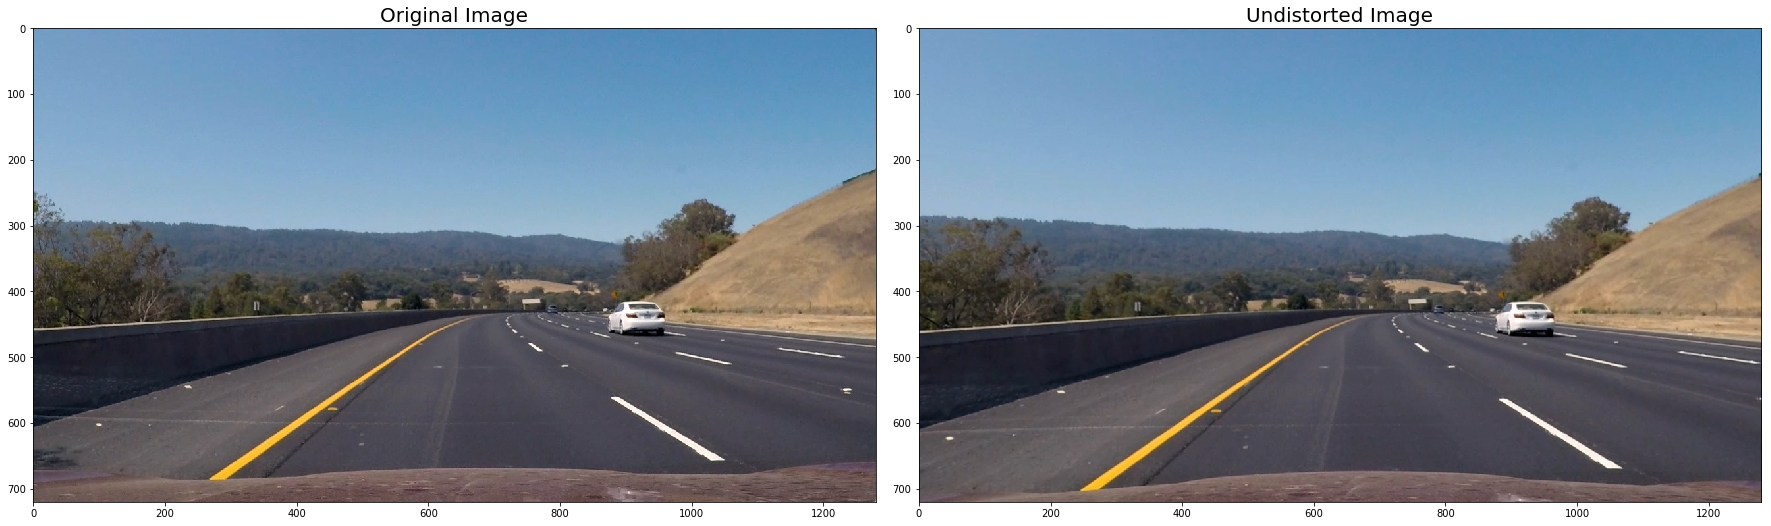

In [52]:
import matplotlib.image as mpimg

def distort_correct(image, mtx, dist):
    img = mpimg.imread(image)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted

test_image = '../test_images/test3.jpg'
test_img = mpimg.imread(test_image)
undistorted = distort_correct(test_image, cam_mtx, cam_dist)

# visualize result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Use color transforms, gradients, etc., to create a thresholded binary image.
####  Experimentally decide to use b-channel in the LAB color space combined with s-channel in HLS color space

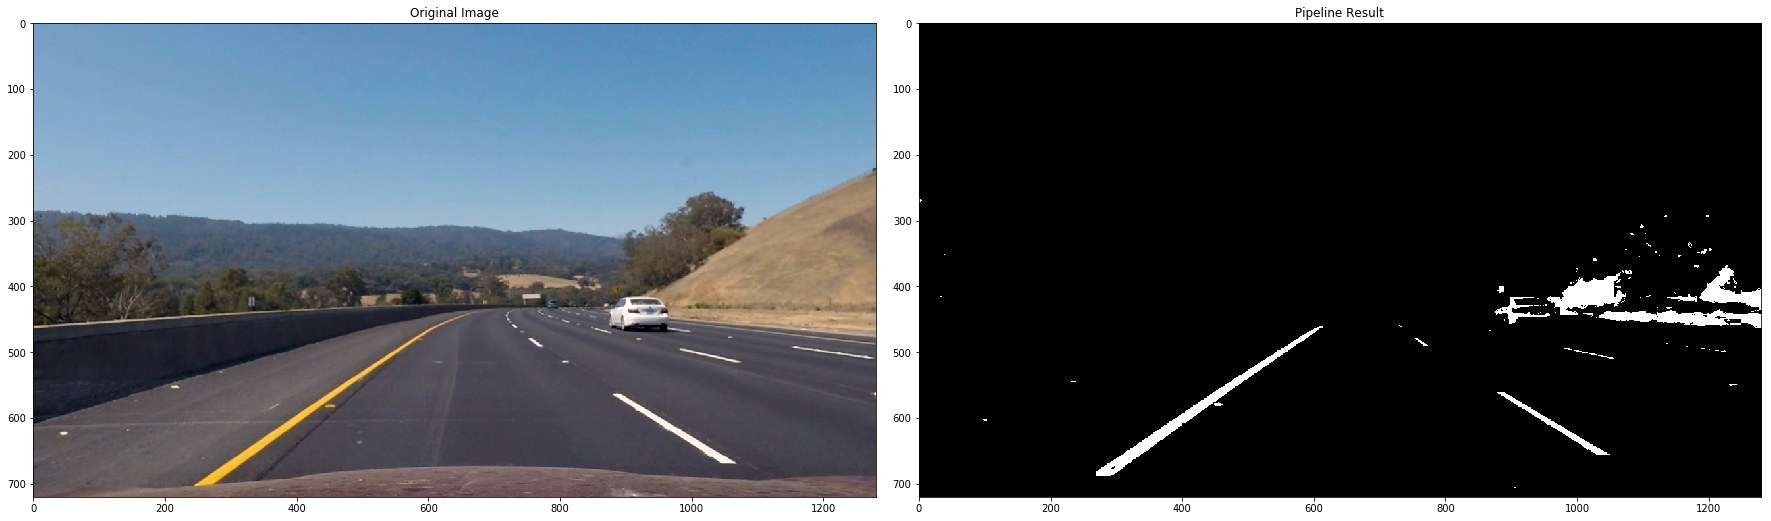

In [53]:
def thresh_gradient(img, sobel_kernel=7, s_thresh=(190, 255),l_thresh=(220, 255), b_thresh=(185,255), sx_thresh=(25, 200)):
    img = np.copy(img)
    # convert to gray
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # convert to lab
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    b_channel = lab[:,:,2]
    
    #Threshold color b-channel
    if np.max(b_channel) > 170:
        b_channel = b_channel*(255/np.max(b_channel))
    lab_binary = np.zeros_like(b_channel)
    lab_binary[((b_channel > b_thresh[0]) & (b_channel <= b_thresh[1]))] = 1
    
    # Sobel magnitude
    sobelx = cv2.Sobel(lab_binary, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) # Take the derivative in y
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        
    # Threshold magnitude gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color s-channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold color L-channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(lab_binary==1) | (l_binary==1)]=1
    #return color_binary
    return combined_binary

bi_result = thresh_gradient(test_img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Original Image')

ax2.imshow(bi_result, cmap='gray')
ax2.set_title('Pipeline Result')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## perspective transform

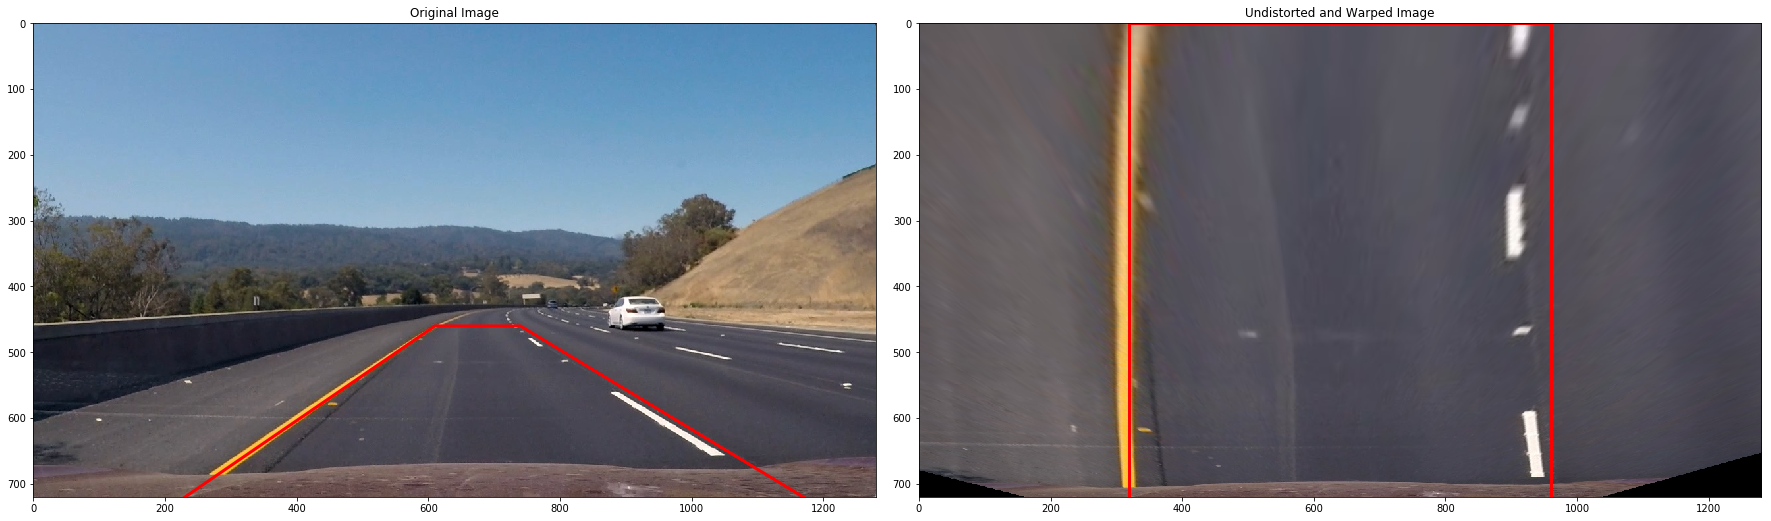

In [55]:
def corners_warp(img):
    img_size = (img.shape[1], img.shape[0])
    # a) define 4 source points src = np.float32([[,],[,],[,],[,]])
    # b) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    # c) use cv2.getPerspectiveTransform() to get M, the transform matrix
    # d) use cv2.warpPerspective() to warp your image to a top-down view
    src = np.float32([[230,720],[610,460],[740,460],[1170,720]])
    dst = np.float32([[320,720],[320,0],[960,0],[960,720]])
    M = cv2.getPerspectiveTransform(src,dst)
    warped = cv2.warpPerspective(img, M, img_size)
    return warped, M, src, dst

top_down, perspective_M, src, dst = corners_warp(test_img)
#top_down = thresh_gradient(top_down)

x1 = src[:,0]
y1 = src[:,1]

x2 = dst[:,0]
y2 = dst[:,1]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.plot(x1,y1,'r-',lw=3)
ax1.imshow(test_img)
ax1.set_title('Original Image')
ax2.plot(x2,y2,'r-',lw=3)
ax2.imshow(top_down, cmap='gray')
ax2.set_title('Undistorted and Warped Image')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Detect lane pixels and fit to find the lane boundary

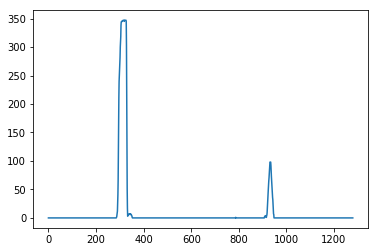

In [56]:
binary_warped = thresh_gradient(top_down)
# peak in a histogram
histogram = np.sum(binary_warped[top_down.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [57]:
def window_search(binary_warped):
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, leftx, lefty, rightx, righty

In [58]:
def fit_using_previous(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    left_fit_new, right_fit_new = (None, None)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fit_new = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit_new = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return(left_fit_new, right_fity_new, leftx, lefty, rightx, righty)

In [59]:
left_fit, right_fit, leftx, lefty, rightx, righty = window_search(binary_warped)

## Visualization

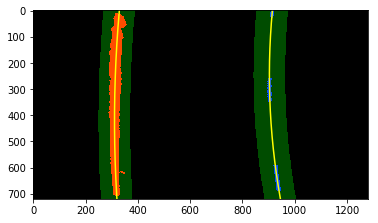

In [60]:
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
margin = 60
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
#plt.xlim(0, 1280)
#plt.ylim(720, 0)

## Warp the detected lane boundaries back onto the original image

In [61]:
def draw_lanes(undistorted, binary_warped, perspective_M, left_fit, right_fit): 
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(0,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,0,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    minv = np.linalg.inv(perspective_M)
    newwarp = cv2.warpPerspective(color_warp, minv, (undistorted.shape[1], undistorted.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    return result

### Result visualization

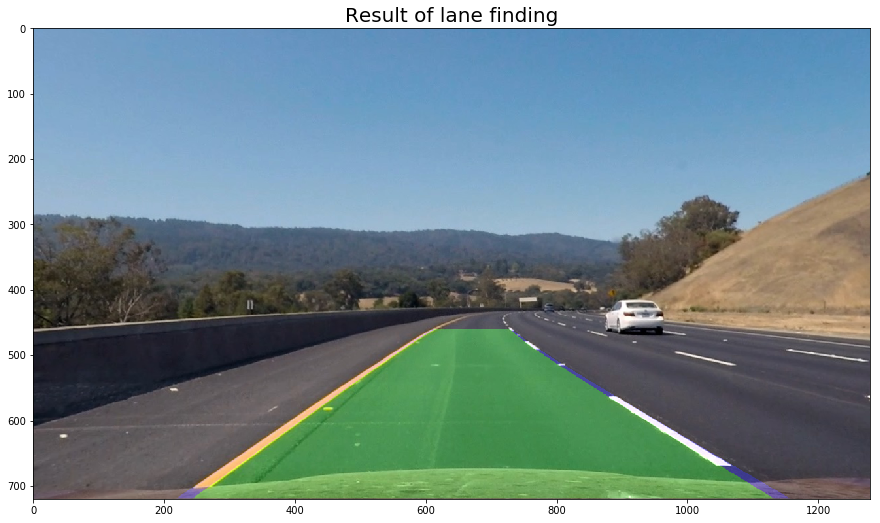

In [64]:
result = draw_lanes(undistorted, binary_warped, perspective_M, left_fit, right_fit)
plt.figure(figsize=(15,10))
plt.imshow(result)
plt.title('Result of lane finding', fontsize=20)

## Determine the curvature of the lane and vehicle position with respect to center

In [66]:
def curvature_center_dist(bi_img, leftx, rightx, lefty, righty, left_fit, right_fit):
    #  calculate curvature in image frame
    h = bi_img.shape[0]
    w = bi_img.shape[1]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    center_curverad = (left_curverad + right_curverad)/2
    car_position = w/2
    left_p = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    right_p = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    lane_center_position = (left_p + right_p)/2
    center_dist = (car_position - lane_center_position) * xm_per_pix
    return center_curverad, left_curverad, right_curverad, center_dist

In [67]:
center_curve,left_curve, right_curve, center_dis = curvature_center_dist(binary_warped, leftx, rightx, lefty, righty, left_fit, right_fit)

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

...


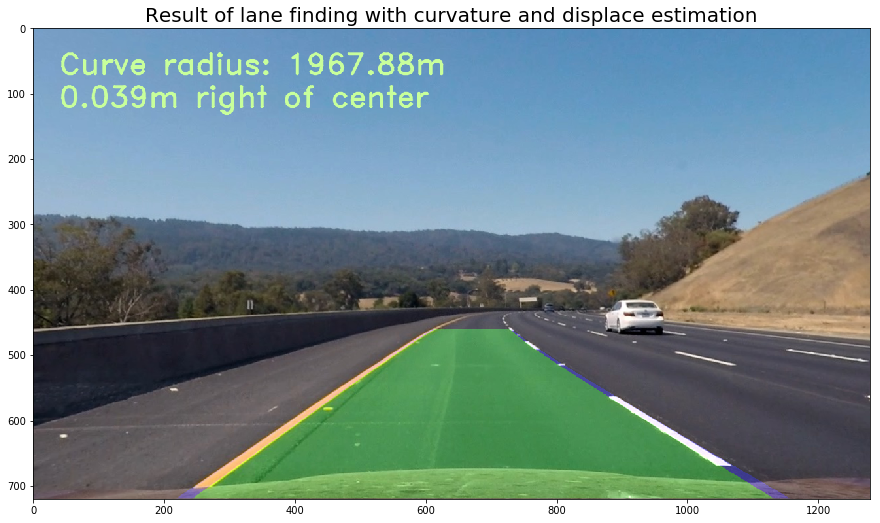

In [69]:
# draw data on the image
def draw_data(original_img, curv_rad, center_dist):
    test_img = np.copy(original_img)
    h = test_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(test_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(test_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return test_img
print('...')

final_demo = draw_data(result, center_curve, center_dis)
plt.figure(figsize=(15,10))
plt.imshow(final_demo)
plt.title('Result of lane finding with curvature and displace estimation', fontsize=20)